In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os


In [ ]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
!tar -xvf images.tar

Streaming output truncated to the last 5000 lines.
Images/n02109047-Great_Dane/n02109047_34148.jpg
Images/n02109047-Great_Dane/n02109047_34162.jpg
Images/n02109047-Great_Dane/n02109047_34209.jpg
Images/n02109047-Great_Dane/n02109047_3643.jpg
Images/n02109047-Great_Dane/n02109047_4267.jpg
Images/n02109047-Great_Dane/n02109047_481.jpg
Images/n02109047-Great_Dane/n02109047_5618.jpg
Images/n02109047-Great_Dane/n02109047_5675.jpg
Images/n02109047-Great_Dane/n02109047_5822.jpg
Images/n02109047-Great_Dane/n02109047_5894.jpg
Images/n02109047-Great_Dane/n02109047_5936.jpg
Images/n02109047-Great_Dane/n02109047_6008.jpg
Images/n02109047-Great_Dane/n02109047_6265.jpg
Images/n02109047-Great_Dane/n02109047_6276.jpg
Images/n02109047-Great_Dane/n02109047_6447.jpg
Images/n02109047-Great_Dane/n02109047_6680.jpg
Images/n02109047-Great_Dane/n02109047_7072.jpg
Images/n02109047-Great_Dane/n02109047_7156.jpg
Images/n02109047-Great_Dane/n02109047_7227.jpg
Images/n02109047-Great_Dane/n02109047_744.jpg
Images/n

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
img_size = (224, 224)
batch_size = 32

In [ ]:
# train dataset

train_ds = tf.keras.utils.image_dataset_from_directory(
    "Images",
    validation_split=0.2, # 80/20 split
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)


Found 20580 files belonging to 120 classes.
Using 16464 files for training.


In [ ]:
# validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    "Images",
    validation_split=0.2, # 80/20 split
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


In [ ]:

class_names = train_ds.class_names
num_classes = len(class_names)
print("Number of breeds:", num_classes)

Number of breeds: 120


# Step 3: Data Augmentation + Prefetch\

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.prefetch(buffer_size=AUTOTUNE)


# Step 4: Build Model (Transfer Learning with ResNet50)
The code below defines the base model for transfer learning using ResNet50,
#### a pre-trained convolutional neural network on the ImageNet dataset.
#### - `tf.keras.applications.ResNet50`: This is the Keras API for the ResNet50 model.
#### - `input_shape=img_size + (3,)`: This sets the expected input shape for the model.
####   `img_size` is a tuple containing the height and width of the images (e.g., (224, 224)).
####   `(3,)` represents the three color channels (Red, Green, Blue). The `+` concatenates
####   these, resulting in an input shape like (224, 224, 3).
#### - `include_top=False`: This argument specifies that the top layer (the classification
####   layer) of the ResNet50 model should not be included. This is because we are
####   using transfer learning for a different classification task (dog breeds),
####   and we will add our own classification layer later.
#### - `weights="imagenet"`: This argument loads the pre-trained weights from the
####   ImageNet dataset. Using these pre-trained weights allows us to leverage the
####   features learned by ResNet50 on a large dataset, which can improve performance
####   on our dog breed classification task, especially with a smaller dataset.

In [ ]:
base_model = tf.keras.applications.ResNet50(
    input_shape=img_size + (3,),
    include_top=False,
    weights="imagenet"
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model.trainable = False  # freeze backbone for transfer learning

- `base_model.trainable = False`: This line sets the `trainable` attribute of the `base_model` to `False`. This means that during the training process, the weights of the ResNet50 model will not be updated. This is a common technique in transfer learning called "freezing" the backbone. By freezing the pre-trained layers, we leverage the powerful feature extraction capabilities that the model learned from the large ImageNet dataset without altering them. We will then add and train new layers on top of this frozen backbone to adapt the model for our specific task of dog breed classification.

In [ ]:
inputs = layers.Input(shape=img_size + (3,))

- `inputs = layers.Input(shape=img_size + (3,))`: This line defines the input layer for the new model.
    - `layers.Input`: This is a Keras function used to instantiate a Keras tensor.
    - `shape=img_size + (3,)`: This specifies the shape of the input data. `img_size` is a tuple (height, width), and `(3,)` represents the three color channels (RGB). Concatenating them results in the shape `(height, width, 3)`, which is the expected format for color images. This means the model will expect input images of the specified size with three color channels.

In [ ]:
x = tf.keras.applications.resnet50.preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)

This code snippet processes the input data and passes it through the frozen ResNet50 base model:

- `x = tf.keras.applications.resnet50.preprocess_input(inputs)`: This line applies the preprocessing function specific to the ResNet50 model to the input data. This function typically scales pixel values and performs other operations to prepare the image data for the ResNet50 model, as it was trained on images preprocessed in a specific way.
- `x = base_model(x, training=False)`: This line passes the preprocessed input data `x` through the `base_model` (the frozen ResNet50).
    - `base_model(x, ...)`: This calls the `base_model` as a function with the input data `x`.
    - `training=False`: This is crucial because the `base_model` is frozen (`base_model.trainable = False`). Setting `training=False` ensures that the model runs in inference mode, meaning it uses its pre-trained weights without updating them through backpropagation. This is the standard practice when using a pre-trained model as a fixed feature extractor.
- `x = layers.GlobalAveragePooling2D()(x)`: This line applies a Global Average Pooling 2D layer to the output of the `base_model`.
    - `layers.GlobalAveragePooling2D()`: This layer calculates the average of all values in each feature map from the previous layer. It reduces the spatial dimensions (height and width) to 1x1, effectively creating a single vector for each feature map. This is a common technique to reduce the number of parameters and computational complexity before the classification layer.
- `x = layers.Dropout(0.3)(x)`: This line adds a Dropout layer.
    - `layers.Dropout(0.3)`: This layer randomly sets 30% of the input units to 0 during training. This helps prevent overfitting by reducing the dependency on specific neurons.

In [ ]:
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = models.Model(inputs, outputs)

These lines define the output layer of the model and create the complete model:

- `outputs = layers.Dense(num_classes, activation="softmax")(x)`: This line adds the final classification layer to the model.
    - `layers.Dense(num_classes, ...)`: This creates a densely connected neural network layer. The first argument, `num_classes`, specifies the number of units in this layer, which corresponds to the number of different dog breeds we are trying to classify.
    - `activation="softmax"`: This sets the activation function for this layer to "softmax". The softmax function converts the raw output scores from the dense layer into a probability distribution over the `num_classes`. Each output value will be between 0 and 1, and the sum of all output values will be 1. This is suitable for multi-class classification problems where each input belongs to exactly one class.
    - `(x)`: This connects the output of the previous layer (`x`, which is the output of the Dropout layer) to this dense layer.
- `model = models.Model(inputs, outputs)`: This line creates the final Keras `Model`.
    - `models.Model`: This is the Keras function used to instantiate a model.
    - `inputs`: This specifies the input layer of the model (the `inputs` defined earlier).
    - `outputs`: This specifies the output layer of the model (the `outputs` defined in the previous line).
    This creates a model that takes the defined `inputs`, passes them through the pre-trained ResNet50 base model (frozen), the Global Average Pooling layer, the Dropout layer, and finally the dense classification layer to produce the `outputs`.

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

This code compiles the model, preparing it for training:

- `model.compile(...)`: This method configures the model for training.
    - `optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)`: This specifies the optimizer to use during training.
        - `tf.keras.optimizers.Adam`: The Adam optimizer is a popular choice for training deep learning models.
        - `learning_rate=1e-4`: This sets the learning rate for the optimizer. A smaller learning rate (like 0.0001) means the model's weights will be updated in smaller steps during training, which can help in converging to a better solution and avoid overshooting.
    - `loss="sparse_categorical_crossentropy"`: This defines the loss function that the model will try to minimize during training.
        - `"sparse_categorical_crossentropy"`: This is a suitable loss function for multi-class classification problems where the target labels are integers (not one-hot encoded). It measures how well the model's predicted probability distribution matches the true distribution.
    - `metrics=["accuracy"]`: This specifies the metrics that will be evaluated during training and testing.
        - `"accuracy"`: This metric calculates the proportion of correctly classified samples. It's a common metric to evaluate the performance of a classification model.

# Step 5: Train

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 256s 469ms/step - accuracy: 0.0706 - loss: 4.6093 - val_accuracy: 0.5046 - val_loss: 2.2767
Epoch 2/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 226s 438ms/step - accuracy: 0.3969 - loss: 2.4860 - val_accuracy: 0.6601 - val_loss: 1.4322
Epoch 3/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 225s 436ms/step - accuracy: 0.5497 - loss: 1.7459 - val_accuracy: 0.7150 - val_loss: 1.1216
Epoch 4/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 230s 446ms/step - accuracy: 0.6379 - loss: 1.4042 - val_accuracy: 0.7357 - val_loss: 0.9703
Epoch 5/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 263s 447ms/step - accuracy: 0.6769 - loss: 1.2028 - val_accuracy: 0.7505 - val_loss: 0.8841
Epoch 6/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 257s 437ms/step - accuracy: 0.6937 - loss: 1.0980 - val_accuracy: 0.7573 - val_loss: 0.8315
Epoch 7/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 226s 438ms/step - accuracy: 0.7227 - loss: 0.9897 - val_accuracy: 0.7721 - val_loss: 0.7883
Epoch 8/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 226s 439ms/step - accuracy: 0.7408 -

# Step 6: Fine-Tune (Optional, after first training)

This section of code demonstrates how to fine-tune the model after the initial training phase. Fine-tuning involves unfreezing some or all of the layers in the pre-trained base model and training them with a very low learning rate. This allows the model to adapt the pre-trained features to the specific dataset (dog breeds in this case).

- `base_model.trainable = True`: This line sets the `trainable` attribute of the `base_model` back to `True`. This unfreezes the weights of the ResNet50 model, allowing them to be updated during the fine-tuning process.
- `model.compile(...)`: This line recompiles the model with a new optimizer and a lower learning rate.
    - `optimizer=tf.keras.optimizers.Adam(1e-5)`: We use the Adam optimizer again, but this time with a significantly lower learning rate (1e-5, which is 0.00001). A lower learning rate is crucial during fine-tuning to avoid drastically changing the pre-trained weights and potentially disrupting the learned features.
    - `loss="sparse_categorical_crossentropy"` and `metrics=["accuracy"]`: The loss function and metrics remain the same as in the initial training, as they are appropriate for the multi-class classification task.
- `history_fine = model.fit(...)`: This line continues the training process with the unfrozen layers and the lower learning rate.
    - `train_ds` and `validation_data=val_ds`: We use the same training and validation datasets.
    - `epochs=5`: We train for an additional 5 epochs. The number of epochs for fine-tuning is typically smaller than the initial training because we are only making small adjustments to the weights.

Fine-tuning can potentially improve the model's performance by allowing it to learn more dataset-specific features, but it also carries the risk of overfitting if not done carefully (e.g., by using too high a learning rate or training for too many epochs).

In [ ]:
base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)


Epoch 1/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 370s 601ms/step - accuracy: 0.7279 - loss: 0.9751 - val_accuracy: 0.7558 - val_loss: 0.8096
Epoch 2/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 272s 527ms/step - accuracy: 0.7960 - loss: 0.7015 - val_accuracy: 0.7648 - val_loss: 0.7684
Epoch 3/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 322s 528ms/step - accuracy: 0.8229 - loss: 0.6130 - val_accuracy: 0.7726 - val_loss: 0.7414
Epoch 4/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 270s 524ms/step - accuracy: 0.8365 - loss: 0.5442 - val_accuracy: 0.7753 - val_loss: 0.7193
Epoch 5/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 273s 530ms/step - accuracy: 0.8565 - loss: 0.4868 - val_accuracy: 0.7811 - val_loss: 0.7093


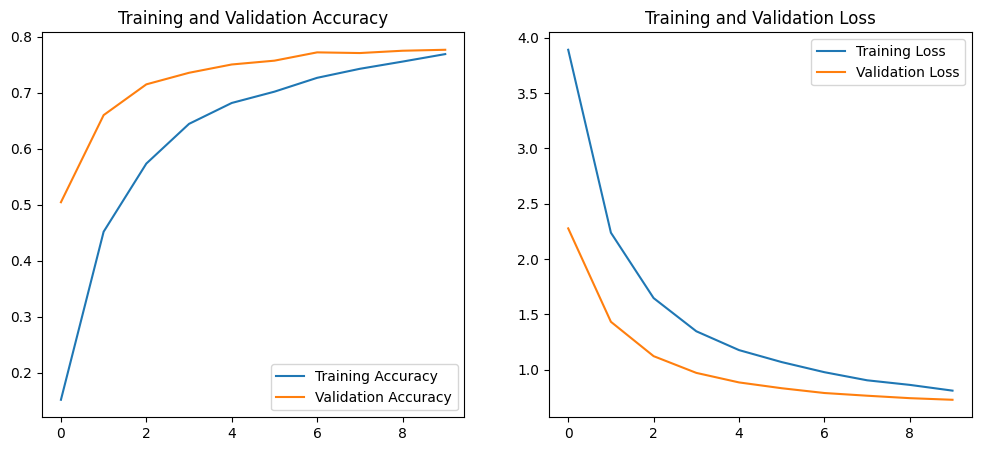

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Path to image you want to test
img_path = "/content/drive/MyDrive/Colab Notebooks/Project Unique/Dog test/hero_belgian_malinois.avif"

# Trying a more common path for mounted Google Drive files
#img_path = "/content/drive/MyDrive/GR.webp"


# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # shape (1, 224, 224, 3)

# Use preprocess_input if using a pretrained backbone
img_array = tf.keras.applications.resnet50.preprocess_input(img_array) # Use resnet50 preprocess_input

# Predict
predictions = model.predict(img_array)  # shape (1, num_classes)
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted Breed: {predicted_class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted Breed: n02105056-groenendael


In [ ]:
model.save("/content/drive/MyDrive/stanford_dogs_model.keras")


In [ ]:
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/stanford_dogs_model.keras")


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 216 variables whereas the saved optimizer has 430 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# 📌 Quick Tip for Google Colab:

# If your dataset is huge, Google Colab GPU sessions may time out. Save the model frequently and use checkpointing:

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("/content/drive/MyDrive/best_model.keras",
                             monitor="val_accuracy",
                             save_best_only=True,
                             mode="max")

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10,
                    callbacks=[checkpoint])

`Earlier we talked about object detection first (YOLO) so the system can:

Detect if a dog is in the image (and crop it out).

Pass the cropped region to the breed classifier (ResNet / custom fine-tuned model).

Then → Adoption API.

So let’s start with a YOLO dog detector sample in Colab.`

# 🐶 YOLO Dog Detection (Sample Test)

We’ll use Ultralytics YOLOv8 (easy to run in Colab).

This code cell demonstrates how to use Ultralytics YOLOv8 for object detection, in this case, to detect dogs in an image. Here's a breakdown:

1.  **Install Libraries**:
    -   `!pip install ultralytics opencv-python-headless matplotlib`: This line uses the `pip` package installer to install the necessary libraries:
        -   `ultralytics`: The library that provides access to YOLOv8 models.
        -   `opencv-python-headless`: The OpenCV library for image processing. The `-headless` version is suitable for environments without a graphical user interface, like Colab.
        -   `matplotlib`: A plotting library used here to display the image with detections.

2.  **Import Libraries**:
    -   `from ultralytics import YOLO`: Imports the `YOLO` class from the `ultralytics` library, which is used to load and run the YOLO model.
    -   `import cv2`: Imports the OpenCV library.
    -   `import matplotlib.pyplot as plt`: Imports the plotting module from Matplotlib.

3.  **Load Pretrained YOLOv8 Model**:
    -   `model = YOLO("yolov8n.pt")`: This line loads a pre-trained YOLOv8 model. `"yolov8n.pt"` refers to the "nano" version of the YOLOv8 model, which is smaller and faster, making it suitable for quick testing or environments with limited resources.

4.  **Download a Sample Dog Image**:
    -   This section downloads a sample image of a Border Collie from a URL and saves it as `sample_dog.jpg`.
        -   `import requests`: Imports the `requests` library for making HTTP requests.
        -   `from PIL import Image`: Imports the `Image` class from the Pillow (PIL) library for image handling (though not directly used for loading in the detection step, it's often useful with image data).
        -   `url = "..."`: Defines the URL of the image.
        -   `img_path = "sample_dog.jpg"`: Sets the filename to save the downloaded image.
        -   `r = requests.get(url, stream=True)`: Sends a GET request to the URL to download the image content in a streaming manner.
        -   `with open(img_path, "wb") as f: f.write(r.content)`: Opens a file in binary write mode (`"wb"`) and writes the downloaded image content to it.

5.  **Run YOLO Detection**:
    -   `results = model(img_path)`: This is the core detection step. The loaded `model` is called as a function with the path to the image (`img_path`). This runs the object detection algorithm on the image and returns the detection `results`.

6.  **Show Detections**:
    -   This section visualizes the detection results by drawing bounding boxes around the detected objects and displaying the image.
        -   `res_plotted = results[0].plot()`: The `results` object contains information about the detections. `results[0]` refers to the results for the first image (since we processed a single image). The `.plot()` method generates an image with the detected objects marked with bounding boxes and class labels.
        -   `plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))`: Displays the image with detections using Matplotlib's `imshow`. `cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)` is used because OpenCV loads images in BGR format, while Matplotlib expects RGB format for correct color display.
        -   `plt.axis("off")`: Turns off the axis labels and ticks for a cleaner image display.
        -   `plt.show()`: Shows the plotted image.

7.  **Print Detected Objects**:
    -   `print("Detections:", results[0].boxes.cls.cpu().numpy())`: Prints the class indices of the detected objects. `results[0].boxes.cls` contains the class IDs as a tensor. `.cpu().numpy()` converts this tensor to a NumPy array on the CPU.
    -   `print("Labels:", [model.names[int(cls)] for cls in results[0].boxes.cls])`: Prints the human-readable class names (labels) for the detected objects by mapping the class indices to the names provided by `model.names`.


0: 448x640 1 dog, 9.3ms
Speed: 3.2ms preprocess, 9.3ms inference, 2.9ms postprocess per image at shape (1, 3, 448, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


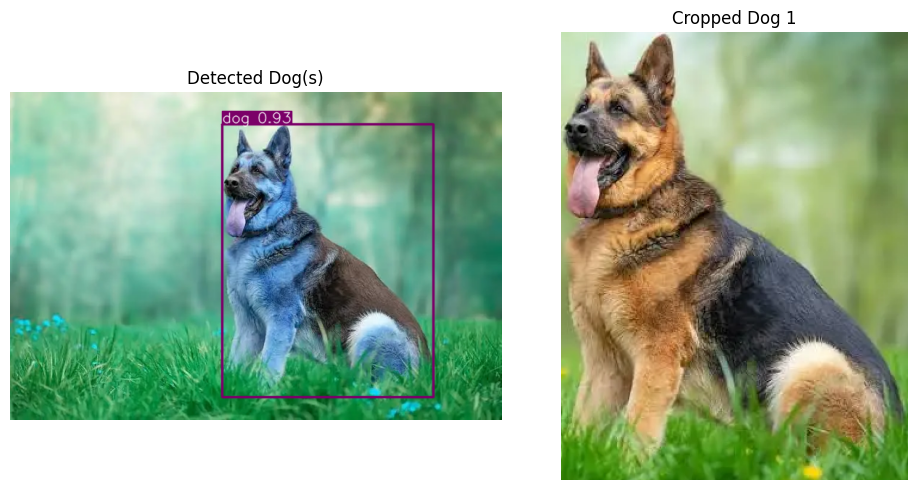

🐕 Dog 1 Breed Predictions:
 - German_shepherd (99.27%)
 - malinois (0.14%)
 - kelpie (0.14%)


In [ ]:
# --------------------------
# Install packages
# --------------------------
!pip install ultralytics opencv-python-headless matplotlib tensorflow

import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image # Import Pillow
from ultralytics import YOLO
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import os

# --------------------------
# 1. Load Models
# --------------------------
detector = YOLO("yolov8n.pt")       # Object detection (dog)
classifier = ResNet50(weights="imagenet")  # Breed classifier

# --------------------------
# 2. Download Sample Dog Image
# --------------------------
url = "https://static.vecteezy.com/system/resources/previews/005/857/332/non_2x/funny-portrait-of-cute-corgi-dog-outdoors-free-photo.jpg"
img_path = "/content/drive/MyDrive/Colab Notebooks/Project Unique/Dog test/zs.webp"
#for second test use online sample for like zerman shapherd
if not os.path.exists(img_path):
    r = requests.get(url, stream=True)
    with open(img_path, "wb") as f:
        f.write(r.content)

# --------------------------
# 3. Run YOLO Detection
# --------------------------
# Load the image using PIL and convert to numpy array
try:
    img_pil = Image.open(img_path).convert('RGB') # Ensure image is in RGB format
    img_array = np.array(img_pil)
    results = detector(img_array) # Pass the numpy array to the model
except Exception as e:
    print(f"Error loading or processing image with PIL: {e}")
    results = None # Set results to None if image loading fails


# --------------------------
# 4. Crop Dog Region - Only proceed if detection was successful
# --------------------------
dog_crops = []
if results and results[0].boxes is not None:
    boxes = results[0].boxes.xyxy.cpu().numpy()  # bounding boxes (x1,y1,x2,y2)
    labels = results[0].boxes.cls.cpu().numpy()

    img_cv = cv2.imread(img_path) # Reload image with cv2 for cropping

    for i, box in enumerate(boxes):
        # Check if the label is within the valid range for COCO dataset and is the dog class (16)
        if int(labels[i]) == 16:  # COCO label 16 = dog
            x1, y1, x2, y2 = map(int, box)
            # Ensure bounding box coordinates are within image dimensions
            h, w, _ = img_cv.shape
            x1, y1, x2, y2 = max(0, x1), max(0, y1), min(w, x2), min(h, y2)
            if x2 > x1 and y2 > y1: # Ensure valid crop dimensions
                dog_crop = img_cv[y1:y2, x1:x2]
                dog_crops.append(dog_crop)
else:
    print("No detections found or error during detection.")


# --------------------------
# 5. Breed Classification - Only proceed if dog crops were created
# --------------------------
predictions = []
if dog_crops:
    # Use the previously trained model for breed classification
    # Ensure the model is loaded or available in the environment
    # Assuming 'model' from previous cells is the breed classifier model
    # If not, load it here:
    #from tensorflow.keras.models import load_model
    #breed_classifier_model = load_model("/content/drive/MyDrive/stanford_dogs_model.keras") # Load your trained model

    # Note: The ResNet50 loaded earlier in this cell is a generic ImageNet classifier, not your trained model.
    # We need to use the 'model' variable from the previous training steps.
    # For demonstration, we'll use the generic ResNet50 for now, but ideally, you'd use your fine-tuned model.
    breed_classifier_model = classifier # Using the ImageNet ResNet50 loaded in this cell for now


    for i, crop in enumerate(dog_crops):
        # Save crop temporarily (optional, but good for verification)
        crop_path = f"dog_crop_{i}.jpg"
        cv2.imwrite(crop_path, crop)

        # Preprocess for breed classification model
        # The target size and preprocessing might differ based on your trained model
        # Assuming your trained model uses 224x224 and resnet50 preprocess_input
        try:
            img = image.load_img(crop_path, target_size=(224,224))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x) # Use resnet50 preprocess_input

            # Predict breed using the breed classifier model
            preds = breed_classifier_model.predict(x)
            # Use your class_names from the trained model
            # Assuming class_names from IALPR5zpUfdr is available
            # If not, you would need to load or define them here
            # For the generic ResNet50, we use decode_predictions
            decoded = decode_predictions(preds, top=3)[0] # Use decode_predictions for generic ResNet50
            predictions.append(decoded)
        except Exception as e:
             print(f"Error classifying dog crop {i}: {e}")
             predictions.append(f"Classification Error: {e}")

# --------------------------
# 6. Display Results
# --------------------------
# Show original with YOLO boxes - Only plot if results are available
if results:
    res_plot = results[0].plot()
    plt.figure(figsize=(10,5))
    plt.subplot(1, max(1, len(dog_crops) + (1 if dog_crops else 0)), 1) # Adjust subplot grid
    plt.imshow(cv2.cvtColor(res_plot, cv2.COLOR_BGR2RGB))
    plt.title("Detected Dog(s)")
    plt.axis("off")

# Show cropped dogs - Only plot if crops were created
if dog_crops:
    for i, crop in enumerate(dog_crops):
        plt.subplot(1, max(1, len(dog_crops) + (1 if results else 0)), i + (2 if results else 1)) # Adjust subplot index
        plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        plt.title(f"Cropped Dog {i+1}")
        plt.axis("off")

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

# Print predictions - Only print if predictions were made
if predictions:
    for i, decoded in enumerate(predictions):
        print(f"🐕 Dog {i+1} Breed Predictions:")
        if isinstance(decoded, list):
            for (imagenet_id, label, score) in decoded:
                print(f" - {label} ({score*100:.2f}%)")
        else:
             print(decoded) # Print error message if classification failed

# For making classes

In [ ]:
import tarfile
import os

tar_path = "/content/drive/MyDrive/Colab Notebooks/Project Unique/Dog Dataset/images.tar"
extract_dir = "/content/drive/MyDrive/Colab Notebooks/Project Unique/Dog Dataset/images"  # where to extract

# Create target directory if not exists
os.makedirs(extract_dir, exist_ok=True)

# Extract
with tarfile.open(tar_path, "r") as tar:
    tar.extractall(path=extract_dir)

print("✅ Extracted to:", extract_dir)


/tmp/ipython-input-2828774917.py:12: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_dir)


✅ Extracted to: /content/drive/MyDrive/Colab Notebooks/Project Unique/Dog Dataset/images


In [ ]:
import os

dataset_dir = "/content/drive/MyDrive/Colab Notebooks/Project Unique/Dog Dataset/images/Images"
folders = sorted(os.listdir(dataset_dir))  # sorted to match training order
class_names = []

for f in folders:
    if os.path.isdir(os.path.join(dataset_dir, f)):  # ensure it's a folder
        name = f.split('-', 1)[-1].replace('_', ' ')
        class_names.append(name)

print("Total classes:", len(class_names))
print("Sample:", class_names[:10])


Total classes: 120
Sample: ['Chihuahua', 'Japanese spaniel', 'Maltese dog', 'Pekinese', 'Shih-Tzu', 'Blenheim spaniel', 'papillon', 'toy terrier', 'Rhodesian ridgeback', 'Afghan hound']


In [ ]:
with open("/content/drive/MyDrive/Colab Notebooks/Project Unique/standfordDogClasses.txt", "w") as f:
    for name in class_names:
        f.write(name + "\n")


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




> Add blockquote





> Add blockquote



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.1 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 216 variables whereas the saved optimizer has 430 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



0: 448x640 1 dog, 77.4ms
Speed: 29.8ms preprocess, 77.4ms inference, 358.5ms postprocess per image at shape (1, 3, 448, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


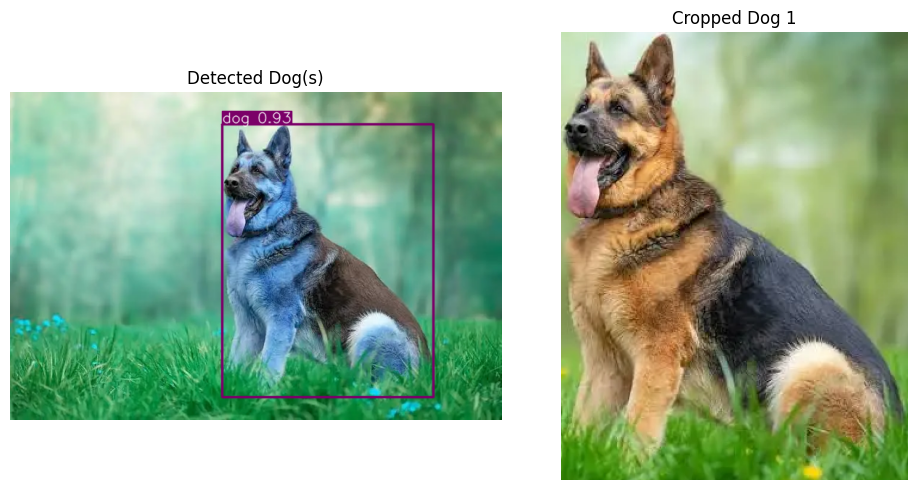

🐕 Dog 1 Breed Predictions:
 - German shepherd (84.19%)
 - Norwegian elkhound (4.34%)
 - malinois (4.27%)


In [2]:
# --------------------------
# Install packages
# --------------------------
!pip install ultralytics opencv-python-headless matplotlib tensorflow

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
from ultralytics import YOLO
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model

# --------------------------
# 1. Load Models
# --------------------------
detector = YOLO("yolov8n.pt")  # YOLOv8 object detector (for dog detection)
breed_classifier_model = load_model("/content/drive/MyDrive/stanford_dogs_model.keras")

# Load your custom breed class names (must match training order)
with open("/content/drive/MyDrive/Colab Notebooks/Project Unique/standfordDogClasses.txt") as f:
    class_names = [line.strip() for line in f]

# --------------------------
# 2. Download or Load a Sample Dog Image
# --------------------------
url = "https://static.vecteezy.com/system/resources/previews/005/857/332/non_2x/funny-portrait-of-cute-corgi-dog-outdoors-free-photo.jpg"
img_path = "/content/drive/MyDrive/Colab Notebooks/Project Unique/Dog test/zs.webp"

if not os.path.exists(img_path):
    r = requests.get(url, stream=True)
    r.raise_for_status()
    with open(img_path, "wb") as f:
        f.write(r.content)

# --------------------------
# 3. Run YOLO Detection
# --------------------------
try:
    img_pil = Image.open(img_path).convert("RGB")  # Ensure RGB
    img_array = np.array(img_pil)
    results = detector(img_array)  # Run YOLO detection
except Exception as e:
    print(f"Error loading or processing image: {e}")
    results = None

# --------------------------
# 4. Crop Dog Regions
# --------------------------
dog_crops = []
if results and results[0].boxes is not None:
    boxes = results[0].boxes.xyxy.cpu().numpy()   # Bounding boxes (x1,y1,x2,y2)
    labels = results[0].boxes.cls.cpu().numpy()   # Class labels
    img_cv = cv2.imread(img_path)                 # Load for cropping (BGR)

    for i, box in enumerate(boxes):
        if int(labels[i]) == 16:  # COCO class 16 = dog
            x1, y1, x2, y2 = map(int, box)
            h, w, _ = img_cv.shape
            x1, y1, x2, y2 = max(0,x1), max(0,y1), min(w,x2), min(h,y2)
            if x2 > x1 and y2 > y1:
                dog_crop = img_cv[y1:y2, x1:x2]
                dog_crops.append(dog_crop)
else:
    print("No dogs detected.")

# --------------------------
# 5. Breed Classification
# --------------------------
predictions = []
if dog_crops:
    for i, crop in enumerate(dog_crops):
        crop_path = f"dog_crop_{i}.jpg"
        cv2.imwrite(crop_path, crop)

        try:
            img = image.load_img(crop_path, target_size=(224,224))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)  # Same preprocessing used in training

            preds = breed_classifier_model.predict(x)  # (1, num_classes)
            probs = preds[0]
            top_indices = probs.argsort()[-3:][::-1]  # Top 3 predictions
            decoded = [(class_names[j], float(probs[j])) for j in top_indices]
            predictions.append(decoded)
        except Exception as e:
            print(f"Error classifying dog crop {i}: {e}")
            predictions.append(f"Classification Error: {e}")

# --------------------------
# 6. Display Results
# --------------------------
if results:
    res_plot = results[0].plot()
    plt.figure(figsize=(10,5))
    plt.subplot(1, max(1, len(dog_crops) + (1 if dog_crops else 0)), 1)
    plt.imshow(cv2.cvtColor(res_plot, cv2.COLOR_BGR2RGB))
    plt.title("Detected Dog(s)")
    plt.axis("off")

if dog_crops:
    for i, crop in enumerate(dog_crops):
        plt.subplot(1, max(1, len(dog_crops) + (1 if results else 0)), i + (2 if results else 1))
        plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        plt.title(f"Cropped Dog {i+1}")
        plt.axis("off")

plt.tight_layout()
plt.show()

# --------------------------
# 7. Print Breed Predictions
# --------------------------
if predictions:
    for i, decoded in enumerate(predictions):
        print(f"🐕 Dog {i+1} Breed Predictions:")
        if isinstance(decoded, list):
            for (breed, score) in decoded:
                print(f" - {breed} ({score*100:.2f}%)")
        else:
            print(decoded)


# ✅  Wrap into a function / API

Instead of running everything in a notebook cell, wrap the pipeline into a function:

In [4]:
import os
import numpy as np
import cv2
from flask import Flask, request, jsonify
from PIL import Image
from ultralytics import YOLO
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input  # Add this import
import tensorflow as tf

print(tf.__version__)

# ----------------------------
# [INFO] Load models
# ----------------------------
print("[INFO] Loading YOLO model...")
yolo = YOLO("yolov8n.pt")

print("[INFO] Loading custom breed model...")
classifier = load_model("/content/drive/MyDrive/stanford_dogs_model.keras")

with open("/content/drive/MyDrive/Colab Notebooks/Project Unique/standfordDogClasses.txt") as f:
    BREED_CLASSES = [line.strip() for line in f]

# ----------------------------
# Helper function
# ----------------------------
def predict_breed(img_path):
    try:
        # Load image as PIL Image first (like in working code)
        img_pil = Image.open(img_path).convert("RGB")
        img_array = np.array(img_pil)

        # Detect dog with YOLO
        results = yolo(img_array)

        # Check if any dogs were detected
        if results[0].boxes is None:
            return {"error": "No dogs detected"}

        boxes = results[0].boxes.xyxy.cpu().numpy()
        labels = results[0].boxes.cls.cpu().numpy()

        # Find the first dog (COCO class 16)
        dog_box = None
        for i, box in enumerate(boxes):
            if int(labels[i]) == 16:  # COCO class 16 = dog
                dog_box = box
                break

        if dog_box is None:
            return {"error": "No dog detected"}

        # Crop the dog region
        x1, y1, x2, y2 = map(int, dog_box)

        # Load image with OpenCV for cropping (like in working code)
        img_cv = cv2.imread(img_path)
        h, w, _ = img_cv.shape

        # Ensure coordinates are within bounds
        x1, y1, x2, y2 = max(0, x1), max(0, y1), min(w, x2), min(h, y2)

        if x2 <= x1 or y2 <= y1:
            return {"error": "Invalid crop dimensions"}

        dog_crop = img_cv[y1:y2, x1:x2]

        # Save cropped image temporarily
        crop_path = "temp_crop.jpg"
        cv2.imwrite(crop_path, dog_crop)

        # Load and preprocess exactly like in working code
        img = image.load_img(crop_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)  # Use ResNet50 preprocessing instead of /255.0

        # Predict
        preds = classifier.predict(x)

        # Get top 3 predictions like in working code
        probs = preds[0]
        top_indices = probs.argsort()[-3:][::-1]  # Top 3 predictions

        top_predictions = []
        for idx in top_indices:
            breed_name = BREED_CLASSES[idx]
            confidence = float(probs[idx])
            top_predictions.append({
                "breed": breed_name,
                "confidence": confidence
            })

        print("Check top predictions---------->", top_predictions)

        # Clean up temporary file
        if os.path.exists(crop_path):
            os.remove(crop_path)

        #return {
        #    "top_prediction": top_predictions[0],
        #    "all_predictions": top_predictions
        #}
        return {
            "breed": top_predictions[0]["breed"],
            "confidence": top_predictions[0]["confidence"]
        }
    except Exception as e:
        print(f"Error in predict_breed: {e}")
        return {"error": str(e)}

# ----------------------------
# Flask API
# ----------------------------
app = Flask(__name__)

@app.route("/predict", methods=["POST"])
def predict():
    if "file" not in request.files:
        return jsonify({"error": "No file uploaded"}), 400

    f = request.files["file"]
    if f.filename == '':
        return jsonify({"error": "No file selected"}), 400

    filepath = os.path.join("uploads", f.filename)
    os.makedirs("uploads", exist_ok=True)
    f.save(filepath)

    try:
        result = predict_breed(filepath)
        # Clean up uploaded file
        if os.path.exists(filepath):
            os.remove(filepath)
        return jsonify(result)
    except Exception as e:
        return jsonify({"error": str(e)}), 500

if __name__ == "__main__":
    app.run(host="0.0.0.0", port=5000, debug=True)

2.19.0
[INFO] Loading YOLO model...
[INFO] Loading custom breed model...
 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with watchdog (inotify)


In [ ]:
print(predict_dog_breed("/content/drive/MyDrive/Colab Notebooks/Project Unique/Dog test/zs.webp"))


image 1/1 /content/drive/MyDrive/Colab Notebooks/Project Unique/Dog test/zs.webp: 448x640 1 dog, 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


NameError: name 'breed_names' is not defined

# For Dog adaptation

In [ ]:
import os
import numpy as np
import cv2
from flask import Flask, request, jsonify
from PIL import Image
from ultralytics import YOLO
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input  # Add this import
import tensorflow as tf

print(tf.__version__)

# ----------------------------
# [INFO] Load models
# ----------------------------
print("[INFO] Loading YOLO model...")
yolo = YOLO("yolov8n.pt")

print("[INFO] Loading custom breed model...")
classifier = load_model("stanford_dogs_model.keras")

with open("standfordDogClasses.txt") as f:
    BREED_CLASSES = [line.strip() for line in f]

# ----------------------------
# Helper function to generate dog links
# ----------------------------
def get_dog_links(breed_name):
    """Generate links for buying/adopting the predicted dog breed"""
    # Clean breed name for URL (replace underscores with spaces, handle special characters)
    clean_breed = breed_name.replace("_", " ").replace("-", " ").title()
    url_breed = breed_name.replace("_", "%20").replace(" ", "%20")

    links = {
        "adoption": {
            "petfinder": f"https://www.petfinder.com/dog-breeds/{breed_name.lower().replace('_', '-')}/",
            https://www.petfinder.com/search/dogs-for-adoption/?breed[]=Golden%20Retriever
            "adopt_a_pet": f"https://www.adoptapet.com/dog-adoption/breed/{url_breed}",
            "rescue_groups": f"https://www.akc.org/dog-breeds/{breed_name.lower().replace('_', '-')}/rescue-groups/"
        },
        "purchase": {
            "akc_marketplace": f"https://marketplace.akc.org/puppies/browse?breed={url_breed}",
            "puppyfind": f"https://www.puppyfind.com/breed/{breed_name.lower().replace('_', '')}",
            "nextdaypets": f"https://www.nextdaypets.com/{breed_name.lower().replace('_', '')}-puppies-for-sale"
        },
        "breed_info": {
            "akc_info": f"https://www.akc.org/dog-breeds/{breed_name.lower().replace('_', '-')}/",
            "dogtime": f"https://dogtime.com/dog-breeds/{breed_name.lower().replace('_', '-')}",
            "wikipedia": f"https://en.wikipedia.org/wiki/{clean_breed}"
        }
    }

    return links

# ----------------------------
# Helper function
# ----------------------------
def predict_breed(img_path):
    try:
        # Load image as PIL Image first (like in working code)
        img_pil = Image.open(img_path).convert("RGB")
        img_array = np.array(img_pil)

        # Detect dog with YOLO
        results = yolo(img_array)

        # Check if any dogs were detected
        if results[0].boxes is None:
            return {"error": "No dogs detected"}

        boxes = results[0].boxes.xyxy.cpu().numpy()
        labels = results[0].boxes.cls.cpu().numpy()

        # Find the first dog (COCO class 16)
        dog_box = None
        for i, box in enumerate(boxes):
            if int(labels[i]) == 16:  # COCO class 16 = dog
                dog_box = box
                break

        if dog_box is None:
            return {"error": "No dog detected"}

        # Crop the dog region
        x1, y1, x2, y2 = map(int, dog_box)

        # Load image with OpenCV for cropping (like in working code)
        img_cv = cv2.imread(img_path)
        h, w, _ = img_cv.shape

        # Ensure coordinates are within bounds
        x1, y1, x2, y2 = max(0, x1), max(0, y1), min(w, x2), min(h, y2)

        if x2 <= x1 or y2 <= y1:
            return {"error": "Invalid crop dimensions"}

        dog_crop = img_cv[y1:y2, x1:x2]

        # Save cropped image temporarily
        crop_path = "temp_crop.jpg"
        cv2.imwrite(crop_path, dog_crop)

        # Load and preprocess exactly like in working code
        img = image.load_img(crop_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)  # Use ResNet50 preprocessing instead of /255.0

        # Predict
        preds = classifier.predict(x)
        print("Check prediction---------->", preds)

        # Get top 3 predictions like in working code
        probs = preds[0]
        top_indices = probs.argsort()[-3:][::-1]  # Top 3 predictions

        top_predictions = []
        for idx in top_indices:
            breed_name = BREED_CLASSES[idx]
            confidence = float(probs[idx])
            top_predictions.append({
                "breed": breed_name,
                "confidence": confidence
            })

        print("Check top predictions---------->", top_predictions)

        # Clean up temporary file
        if os.path.exists(crop_path):
            os.remove(crop_path)

        # Get links for the predicted breed
        breed_links = get_dog_links(top_predictions[0]["breed"])

        return {
            "breed": top_predictions[0]["breed"],
            "confidence": top_predictions[0]["confidence"],
            "links": breed_links
        }

    except Exception as e:
        print(f"Error in predict_breed: {e}")
        return {"error": str(e)}

# ----------------------------
# Flask API
# ----------------------------
app = Flask(__name__)

@app.route("/predict", methods=["POST"])
def predict():
    if "file" not in request.files:
        return jsonify({"error": "No file uploaded"}), 400

    f = request.files["file"]
    if f.filename == '':
        return jsonify({"error": "No file selected"}), 400

    filepath = os.path.join("uploads", f.filename)
    os.makedirs("uploads", exist_ok=True)
    f.save(filepath)

    try:
        result = predict_breed(filepath)
        # Clean up uploaded file
        if os.path.exists(filepath):
            os.remove(filepath)
        return jsonify(result)
    except Exception as e:
        return jsonify({"error": str(e)}), 500

@app.route("/breed-links/<breed_name>", methods=["GET"])
def get_breed_links(breed_name):
    """Get adoption/purchase links for a specific breed"""
    try:
        links = get_dog_links(breed_name)
        return jsonify({
            "breed": breed_name,
            "links": links
        })
    except Exception as e:
        return jsonify({"error": str(e)}), 500

@app.route("/redirect/<link_type>/<breed_name>", methods=["GET"])
def redirect_to_site(link_type, breed_name):
    """Direct redirect to specific adoption/purchase sites"""
    from flask import redirect

    try:
        links = get_dog_links(breed_name)

        # Define redirect mappings
        redirect_map = {
            "petfinder": links["adoption"]["petfinder"],
            "adoptapet": links["adoption"]["adopt_a_pet"],
            "akc-marketplace": links["purchase"]["akc_marketplace"],
            "puppyfind": links["purchase"]["puppyfind"],
            "breed-info": links["breed_info"]["akc_info"]
        }

        if link_type in redirect_map:
            return redirect(redirect_map[link_type])
        else:
            return jsonify({"error": "Invalid link type"}), 400

    except Exception as e:
        return jsonify({"error": str(e)}), 500

if __name__ == "__main__":
    app.run(host="0.0.0.0", port=5000, debug=True)